# NTDS Project : Expression Transfer

## Visualization

*Matplotlib* do not cope well with large scale 3D data visualization. This can be overcomed by the use of `mayavi` package (*build on top of OpenGL pipeline*). It can be installed on your machine with the following commands:

```
$ conda install -c clinicalgraphics vtk=7.1.0
$ pip install mayavi
```

In order to use it in `Jupyter` notebook, some extension need to be installed. The command listed below will do it:

```
$ jupyter nbextension install --py mayavi --user
```

When launching the notebook, the following command need to be issued in order to load the extensions:

```
$ jupyter nbextension enable mayavi --user --py
```

## Quaternion

Rotation is represented using *Quaternion* representation, therefore the package `pyquaternion` is mandatory and can be installed using `pip install pyquaternion`

In [2]:
%matplotlib inline

import utils 
import numpy as np
from tqdm import tqdm, tnrange, tqdm_notebook
import os, sys
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
from scipy.sparse import csgraph
from sklearn import preprocessing, decomposition, neighbors, cluster
from IPython.display import display, Image

# Visualization
# Need to install some package before: 
# conda install -c clinicalgraphics vtk=7.1.0
# pip install mayavi
from mayavi import mlab
mlab.init_notebook()

plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
# Load 1st person mesh
tri = utils.load_triangulation('../data/FWTri/fw_triangulation.tri')
mesh_0 = utils.load_meshes('../data/FWMesh/000_shape.bs')

# Load 150th person mesh
mesh_149 = utils.load_meshes('../data/FWMesh/149_shape.bs')


# Face of interest
midx = 2

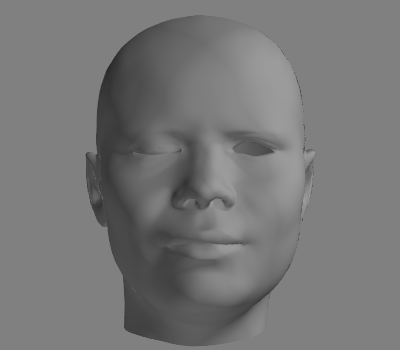

In [4]:
# Display mesh 0
mlab.clf()
midx = 2
color = (0.5, 0.5, 0.5)
trimesh_0 = mlab.triangular_mesh(mesh_0[midx][:,0], mesh_0[midx][:,1], mesh_0[midx][:,2], tri, color=color)

mlab.view(0,0)

mlab.savefig(filename='mesh_0.png')
display(Image(filename='mesh_0.png'))

# Uncomment to display interactive mesh
# trimesh_0

## Loading Train and Test sets

The complete dataset of meshes contains 46 differents faces for 150 persons, mainly asians. In order to classify or find the different clusters, a train and a test sets are created with a ratio of 75% of the samples for the train set and the rest used for the test set.

In [5]:
folder_path = '../data/FWMesh/'
individuals, individuals_test = utils.load_set(0.75,folder_path)

A Jupyter Widget

A Jupyter Widget

## Classification approach
(Using Subject's neutral face)

In this section, we aim to learn 15 different faces and then being able to classify a face from a new person. The expressive face is therefore compared to the neutral face of each subject.

### Extracting features for both train and test sets

A feature matrix is created. Face[0] of an individual corresponds to its neutral face whereas the faces from index 1 until index 15 are facial expressions that results from movements around the eyes. To reduce the computational load, only the 15 first faces are considered.

The difference between the expressive faces and the neutral one is calculated for each node of the meshes in the three dimensions x, y and z. This error per node per dimension build the feature matrix.

The length of this matrix corresponds to the length of the train set multiplied by the number of expressive face, in our case $112*14$.

In [6]:
nb_face = 15
expression_label, features = utils.construct_features_matrix(individuals, nb_face)
expression_label_test, features_test = utils.construct_features_matrix(individuals_test, nb_face)


A Jupyter Widget

A Jupyter Widget

### Compute Laplacian, eigenvectors and eigenvalues.

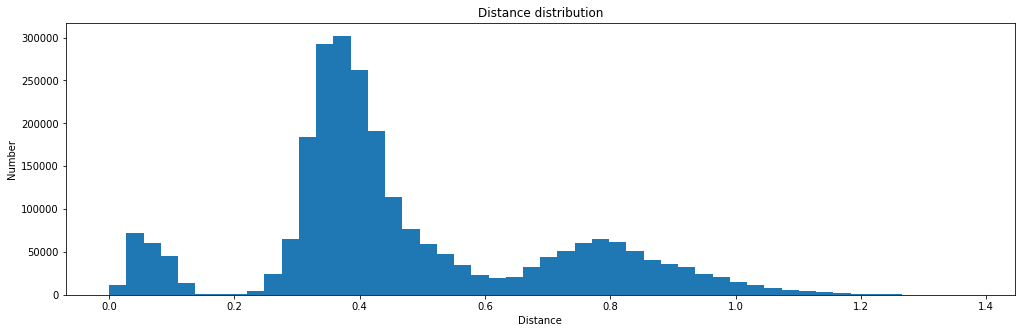

A Jupyter Widget

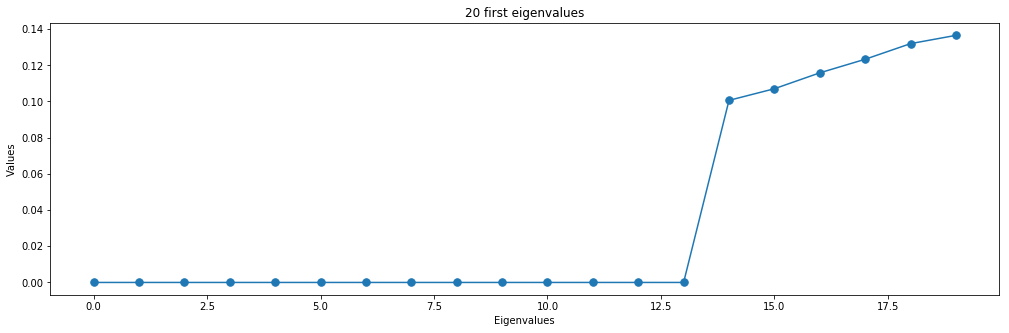

In [7]:
eigenvalues, eigenvectors = utils.compute_laplacian(features, nb_neighbours = 10, distance_metric = 'euclidean', nb_eigen = 20, verbose=1)

Calculating the eigenvalues enables to find the number of cluster inherent of the features. Here, we find 14 eigenvalues with values equals to zero and therefore it matches the 14 different expressive faces.

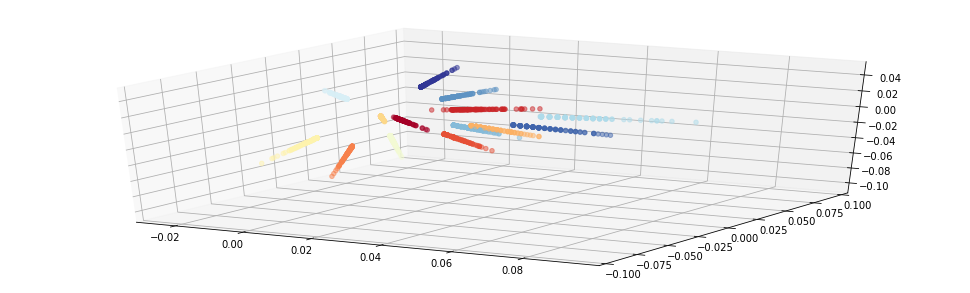

In [8]:
x = eigenvectors[:,3]
y = eigenvectors[:,13]
z = eigenvectors[:,1]

types = preprocessing.LabelEncoder().fit_transform(expression_label)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(x, y, z, c=expression_label, cmap='RdYlBu', alpha=0.5);

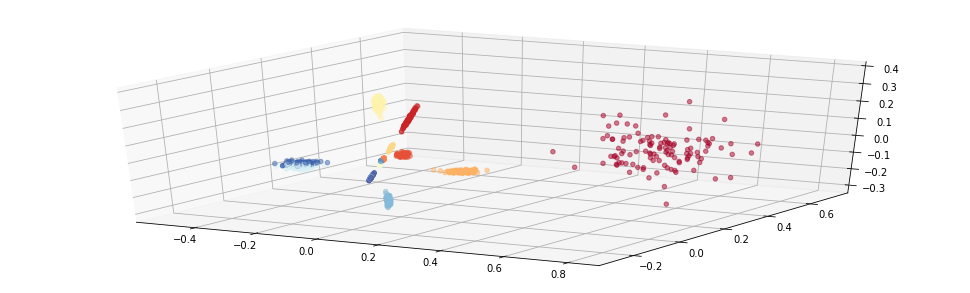

In [9]:
features_pca = decomposition.PCA(n_components=3).fit_transform(features)
genres = preprocessing.LabelEncoder().fit_transform(expression_label)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c=genres, cmap='RdYlBu', alpha=0.5);

With the two plots above, we can see that similar expressions form 14 clusters clearly separated, especially when using the eigenvectors as coordinates.

### Machine Learning: kNN

In [10]:
n_neighbors = nb_face
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(features, expression_label)

Z = clf.predict(features_test)

In [11]:
error_clf = np.count_nonzero(Z-expression_label_test)
error_clf

0

A k-Nearest Neighbors classifier is trained and then tested on the test set. As we can see, all new faces are correctly classified which shows that the model is perfectly able to recognize each facial expression.

## Clustering approach

### 1- Expressions clustering

The goal here it to suppose that we do not know the number of different facial expressions. This number will be found with the number of eigenvalues equals to zero and then a classifier is trained in order to regroup identical facial expressions. 

In this section, the same feature matrix as above is used. Nevertheless, the eigenvectors are used as features for the machine learning part. This choice reduce the computational load while keeping discriminant informations.

### Machine Learning: KMeans 

First, we train the classifier.

In [12]:
nb_cluster = len(eigenvalues[eigenvalues < 0.02])
cluster_features = cluster.KMeans(nb_cluster).fit(eigenvectors[:,:nb_cluster])

### Compute Laplacian for the test set

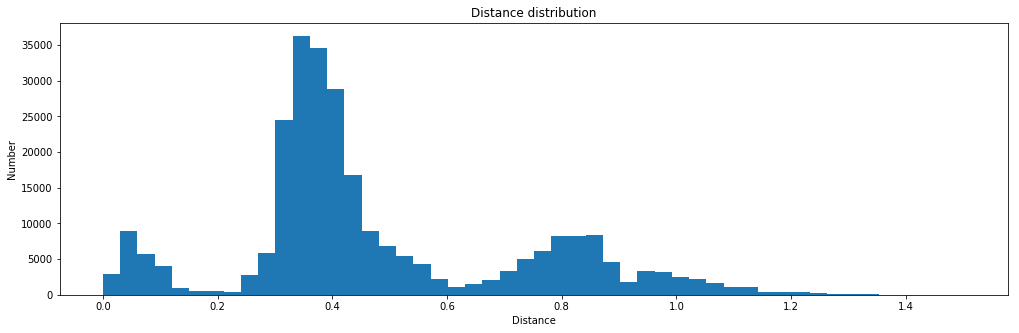

A Jupyter Widget

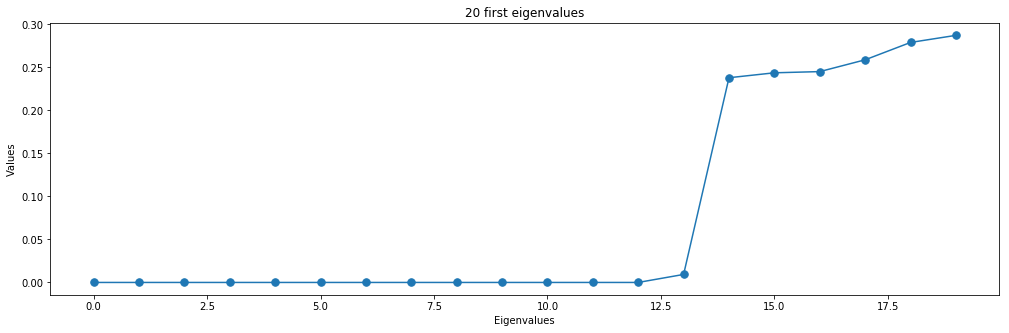

In [13]:
eigenvalues_test, eigenvectors_test = utils.compute_laplacian(features_test, nb_neighbours = 10, 
                                                        distance_metric = 'euclidean', nb_eigen = 20, verbose=1)

Again, we can see that the eigenvalues fit the number of clusters.

(array([ 74.,   0.,  37.,  37.,  37.,  37.,  37.,  37.,  40.,  34.,   0.,
         37.,  37.,  74.]),
 array([  0.        ,   0.92857143,   1.85714286,   2.78571429,
          3.71428571,   4.64285714,   5.57142857,   6.5       ,
          7.42857143,   8.35714286,   9.28571429,  10.21428571,
         11.14285714,  12.07142857,  13.        ]),
 <a list of 14 Patch objects>)

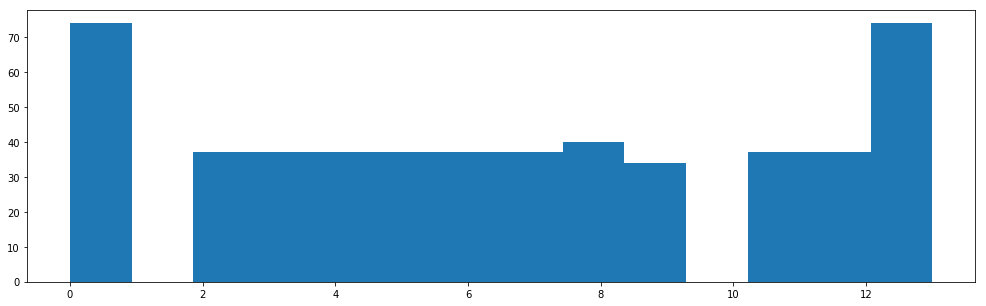

In [14]:
prediction = cluster_features.predict(eigenvectors_test[:,:nb_cluster])
plt.hist(prediction, bins=14)

In this plot, we can observe that the model, on average, can correctly aggregate identical facial expressions. Nevertheless, it fails to recognize two expressions and mixes the meshes with another face which might be really close of the other one.

### 2- Ethnies clustering

Now, another dataset containing caucasian faces is added. We will see if a kMeans classifier is able to differentiate between ethnies.

### Load dataset

In [15]:
folder_path = '../data/LTS5Mesh/'
caucasian, caucasian_test = utils.load_set(0.75,folder_path)

A Jupyter Widget

A Jupyter Widget

In [16]:
totals = list(individuals)
totals.extend(caucasian)
totals_test = list(individuals_test)
totals_test.extend(caucasian_test)

In [17]:
len(totals[113])

1

The caucasian dataset contains 120 samples. With the split ratio between train and test set, 90 caucasian samples are assigned to the train set whereas 30 are in the test set.

### Construct features matrix 

In order to compare the two ethnies, only the neutral face is used.

In [18]:
nb_face = 0
expression_label, neutrals = utils.construct_features_matrix(totals, nb_face)
expression_label_test, neutrals_test = utils.construct_features_matrix(totals_test, nb_face)

A Jupyter Widget

A Jupyter Widget

### Compute Laplacian for both sets

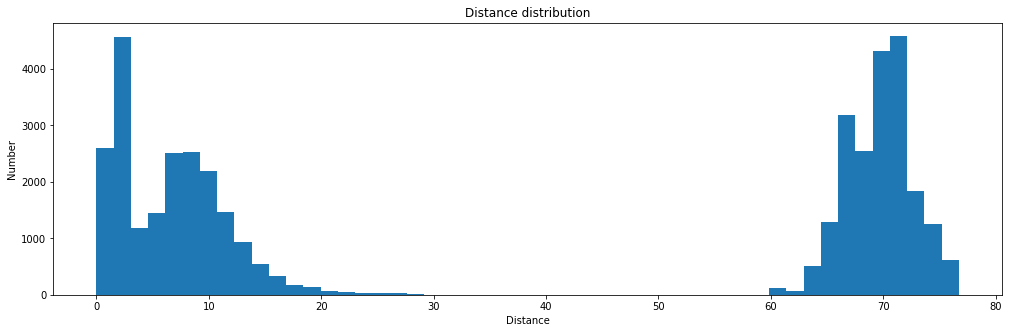

A Jupyter Widget

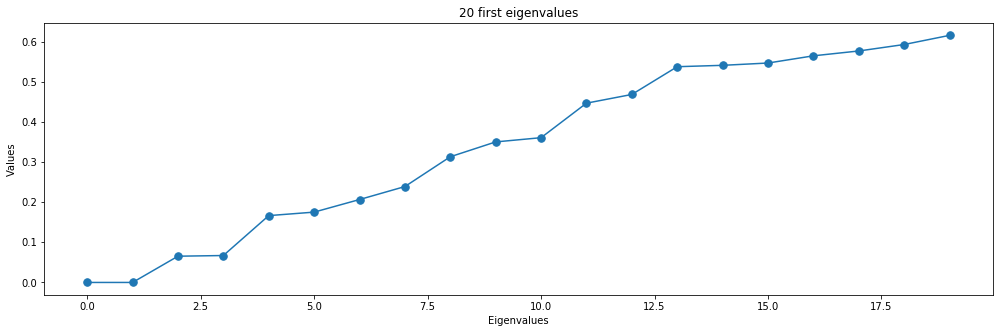

In [19]:
eigenvalues_neutral, eigenvectors_neutral = utils.compute_laplacian(neutrals, nb_neighbours = 10, distance_metric = 'euclidean', nb_eigen = 20, verbose=1)

In [20]:
nb_cluster_neutral = len(eigenvalues_neutral[eigenvalues_neutral < 0.02])
cluster_features = cluster.KMeans(nb_cluster_neutral).fit(eigenvectors_neutral[:,:nb_cluster_neutral])

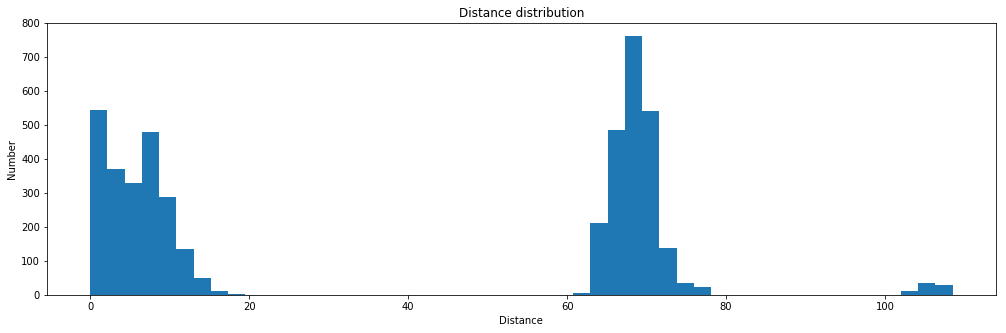

A Jupyter Widget

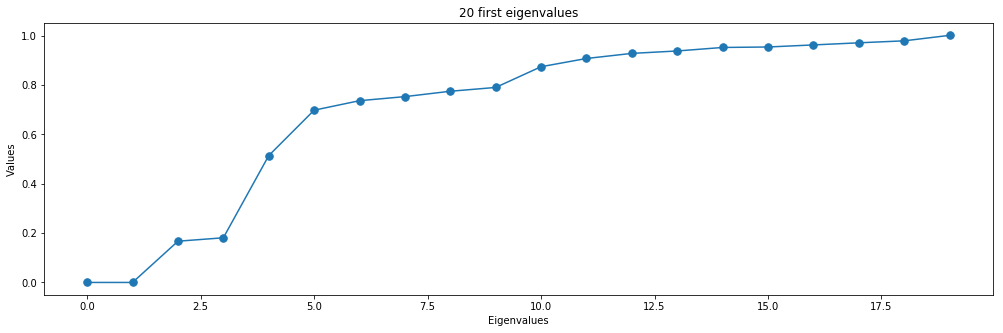

In [21]:
eigenvalues_neutral_test, eigenvectors_neutral_test = utils.compute_laplacian(neutrals_test, nb_neighbours = 10, 
                                                        distance_metric = 'euclidean', nb_eigen = 20, verbose=1)

We can see in the plots above that in both sets, the distances and the eigenvalues indicate that we have two clusters. From this point we could be confident that our model will be able to differentiate between ethnies.

### Machine learning: K Means

(array([ 37.,  30.]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)

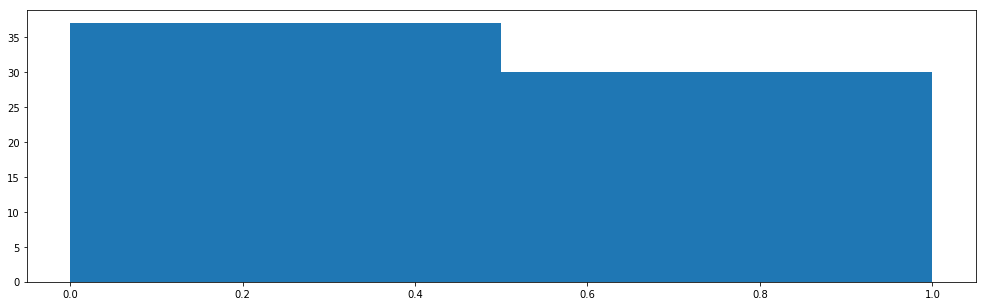

In [22]:
prediction = cluster_features.predict(eigenvectors_neutral_test[:,:nb_cluster_neutral])
plt.hist(prediction, bins=nb_cluster_neutral)

Here, we can observe that the model is able to differentiate the two ethnies, asians and caucasians. Indeed, we have in our group the 30 samples that are caucasians and the rest that corresponds to the number of asians in the test set.

## Deformation a.k.a FaceSomething

The feature matrix is composed so far of the vectors of differences between a given face mesh and the neutral face mesh of each individual.    

This classification is thus limited. Indeed, in order to classify one random face, we need the neutral face of the individual. The dataset is well designed and all the meshes are normalised and have the same nomenclatures. Hence, we will try to compute a average neutral face so that given a random face, we can extract its feature vector using that averaged neutral face. 

To illustrate how the faces are normalised, here is a quick application where the deformation from the neutral face to a specific expression from one individual is computed and then applied on a new neutral face of someone else. The constructed deformation is compared to the real face made by this new person.  

Here, we applied difference from neutral face to face n°2 from subject n°0 to the neutral face from subject n°2

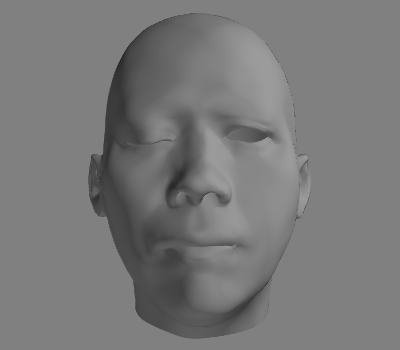

In [23]:
folder_path = '../data/FWMesh/'
filenames = pd.Series(os.listdir(folder_path)).sort_values()
tri = utils.load_triangulation('../data/FWTri/fw_triangulation.tri')

mesh_0 = utils.load_meshes(folder_path + filenames[0])
err = mesh_0[0] - mesh_0[2]

mesh_3 = utils.load_meshes(folder_path + filenames[12])
visage_def = mesh_3[0]-err

mlab.clf()
color = (0.5, 0.5, 0.5)
trimesh = mlab.triangular_mesh(visage_def[:,0], visage_def[:,1], visage_def[:,2], tri, color = color)
mlab.view(0,0)

mlab.savefig(filename='mesh_transformed.png')
display(Image(filename='mesh_transformed.png'))

# Uncomment to display interactive mesh
# trimesh

## Other attempts: Learn with a common neutral averaged face

### Create averaged neutral face

In [24]:
neutrals = [ind[0] for ind in individuals]
neutrals = np.array(neutrals)
neutrals_avg = neutrals.mean(0)
neutrals_avg.shape

(11510L, 3L)

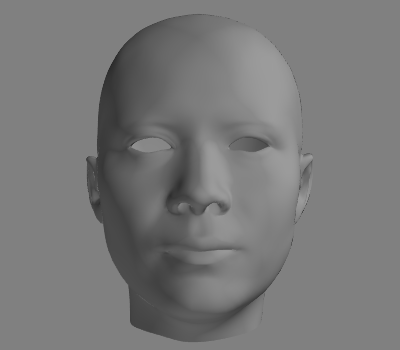

In [25]:
tri = utils.load_triangulation('../data/FWTri/fw_triangulation.tri')

mlab.clf()
color = (0.5, 0.5, 0.5)
trimesh_avg = mlab.triangular_mesh(neutrals_avg[:,0], neutrals_avg[:,1], neutrals_avg[:,2], tri, color=color)
mlab.view(0,0)

mlab.savefig(filename='mesh_neutre_avg.png')
display(Image(filename='mesh_neutre_avg.png'))

# Uncomment to display interactive mesh
# trimesh_avg

In order to have a more precise analysis, the features matrix is reduced to only meaningful nodes (ex : remove nodes related to the back of the head). Therefore, we keep the nodes that have non-zero values when computing the vectors of difference between faces and neutral face. We know for sure the vector of difference between faces and averaged neutral face will be noisy.
  
"index_err" contains all the indices of these nodes.

In [26]:
nb_face=15 

for j,face in enumerate(individuals[0][1:nb_face]):
        if j == 0:
            features_err = face.reshape(1,-1) - individuals[0][0].reshape(1,-1)
        else:
            err = face.reshape(1,-1) - individuals[0][0].reshape(1,-1)
            features_err = np.vstack((features_err, err))

features_err.sum(0)
index_err = [i for i, j in enumerate(features_err.sum(0)) if j != 0]

### Compute features for train and test sets

Here we compute the features matrices for train set and test set using the neutral averaged face and the indices of the meshes we selected above. 

In [27]:
features_avg = []

for i,ind in enumerate(tqdm_notebook((individuals),desc = 'Built Features')):
    for j,face in enumerate(ind[1:nb_face]):
        if (i == 0 and j == 0):
            features_avg = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
        else:
            err = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
            features_avg = np.vstack((features_avg, err))

A Jupyter Widget

In [28]:
for i,ind in enumerate(tqdm_notebook((individuals_test),desc = 'Built Features')):
    for j,face in enumerate(ind[1:nb_face]):
        if (i == 0 and j == 0):
            features_avg_test = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
        else:
            err = face.reshape(1,-1)[:,index_err] - neutrals_avg.reshape(1,-1)[:,index_err]
            features_avg_test = np.vstack((features_avg_test, err))

A Jupyter Widget

### Compute Laplacian

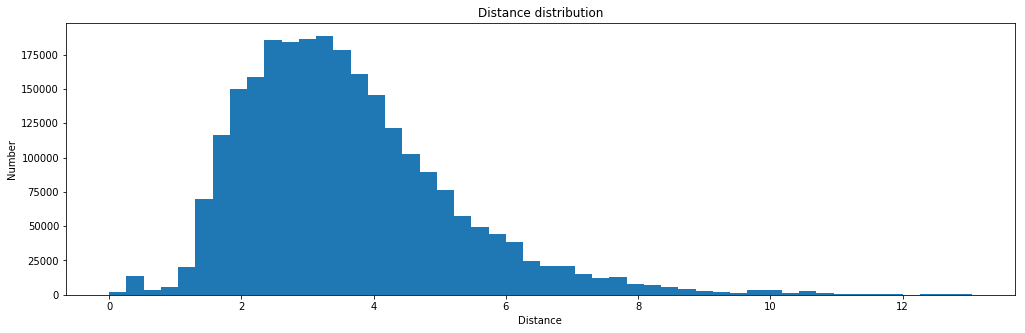

A Jupyter Widget

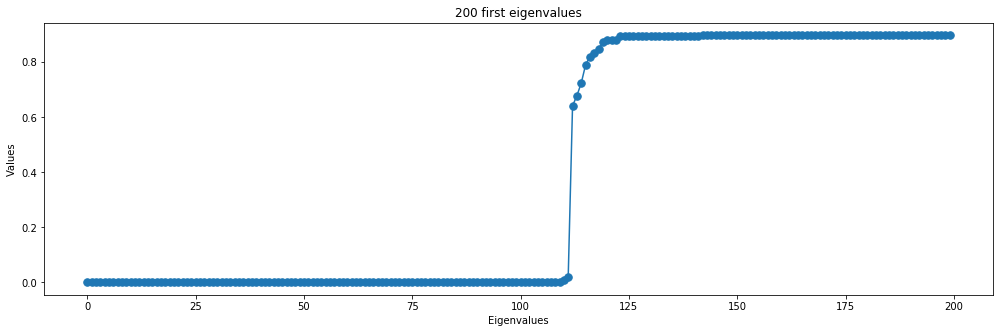

In [29]:
eigenvalues_avg, eigenvectors_avg = utils.compute_laplacian(features_avg, nb_neighbours = 10, distance_metric = 'euclidean', nb_eigen = 200, verbose=1)

We see from the graph of the eigenvalues we have approximatively 115  zero eigenvalues meaning we have 115 connected subgraphs, corresponding, we believe, to the 113 individuals from the train set. 
Thus, we conclude the use of the averaged neutral face is not convincing since it does not allow a clustering of the different kind of faces.

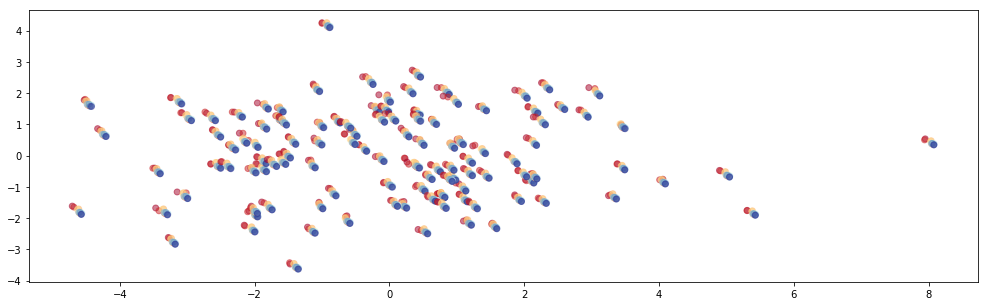

In [37]:
expression_label = [j for i in range(0,len(individuals)) for j in range(1,nb_face)]

features_pca = decomposition.PCA(n_components=3).fit_transform(features_avg)
genres = preprocessing.LabelEncoder().fit_transform(expression_label)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=expression_label, cmap='RdYlBu', alpha=0.5);
plt.show()

On this graph we see clustering of dots with different colors that may be all kind of faces grouped by individuals.